In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pathlib
from numpy.polynomial import Polynomial
import sys

sys.path.append('../')
from common_util import ProjectPaths,setup_plotting_format,setup_axis_default
paths = ProjectPaths()
#ignore warnings and set preference for matplotlib styles
import warnings

warnings.filterwarnings("ignore")
setup_plotting_format()

### Prepare Roedig Data

### ITER MPH Model
Reccomended thermal conductivities from the ITER Material Property Handbook (MPH)

In [3]:
iterw_poly = Polynomial(np.array([174.9274,-0.1067,5.0067e-5,-7.8349e-9]))
iterwl10_poly = Polynomial(np.array([124.3,-0.04148,1.443e-5]))
xplot_iter = np.linspace(20,3500,1000)
corrected = Polynomial.fit(xplot_iter + 273.15,iterw_poly(xplot_iter),3)

### Visualize the Data and Models
Plotted below are data and models for tungsten and tungsten alloys available from the literature. There is clearly a large difference in conductivities at lower temperatures, while the conductivity tends to converge towards a commonn value at higher temperatures. 

Additionally, we see a considerable discrepency in models reccomended by ITER MPH vs. data available in the literature, highlighting the discrepncy between results for ostensibly identical materials. This is typically because of the enourmous complexitiy in manufacturing refactory alloys can lead to different results.

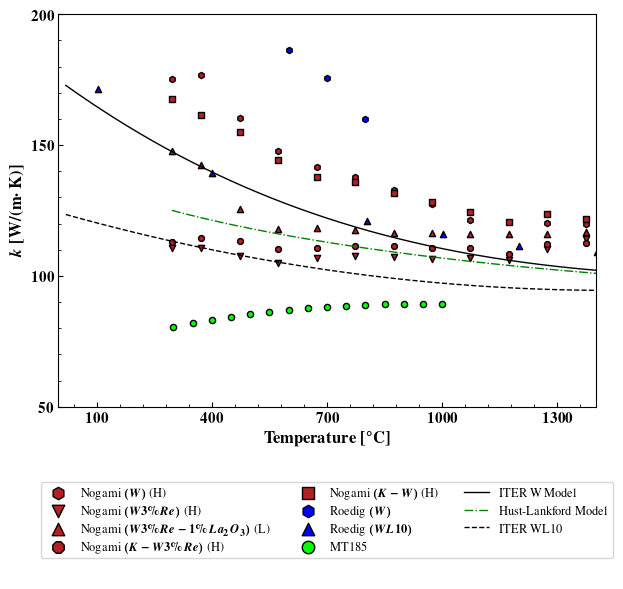

In [5]:
import pickle

MARKER_SIZE = 20
ALPHA = 1.0

def hl_model(x: np.ndarray) -> np.ndarray:
    poly_hl = Polynomial([137.976060119897,-0.03859083192697,1.19769362e-5,-1.484e-9])
    return poly_hl(x) + 3.866e6/(x + 273.15)**2

fig,axes = plt.subplots(nrows =  2,figsize = (6.5,6),height_ratios = [1,0.3])
ax = axes[0]
legend_ax = axes[1]
setup_axis_default(ax)

nogami_label_map = {'Pure W (H) Plate': 'Nogami $(W)$ (H)',
                     'W-3%Re (H) Plate': r'Nogami  $(W3\%Re)$ (H)',
                     'W-1%Re (H) Plate': r'Nogami $(W3\%Re-1\%La_2O_3)$  (L)',
                     'K-doped W-3%Re (H) Plate': r'Nogami $(K-W3\%Re)$ (H)',
                     'K-doped W (H) Plate': r'Nogami $(K-W)$ (H)'}


nogami_marker_map = {'Pure W (H) Plate': 'h',
                     'W-3%Re (H) Plate': 'v',
                     'W-1%Re (H) Plate': '^',
                     'K-doped W-3%Re (H) Plate': '8',
                     'K-doped W (H) Plate': 's'}  

nogami_df = pd.read_csv(paths.CONDUCTIVITY_DATA.joinpath('nogami_data.csv'),index_col = 0)
for col in nogami_label_map:
    ax.scatter(nogami_df.index,nogami_df[col].to_numpy(),s =MARKER_SIZE if col != 'K-doped W-3%Re (H) Plate' else MARKER_SIZE,
               marker = nogami_marker_map[col],edgecolor = 'k',facecolor = 'firebrick',alpha = ALPHA if col != 'K-doped W-3%Re (H) Plate' else 1,
               label = nogami_label_map[col])

roedig_label_map = {'Pure W': 'Roedig $(W)$', 
                     'WL10': 'Roedig $(WL10)$'}

roedig_marker_map = {'Pure W': 'h', 
                     'WL10': '^'}


roedig_df = pd.read_csv(paths.CONDUCTIVITY_DATA.joinpath('roedig_data.csv'),index_col = 0)
for col in roedig_label_map:
    ax.scatter(roedig_df.index - 273.15,roedig_df[col].to_numpy(),s =MARKER_SIZE,
               marker = roedig_marker_map[col],edgecolor = 'k',facecolor = 'blue',
               label = roedig_label_map[col],alpha = ALPHA)

mt185_df = pd.read_csv(paths.CONDUCTIVITY_DATA.joinpath('mt185_data.csv'),index_col = 0)
ax.scatter(mt185_df.index,mt185_df.to_numpy(),s = MARKER_SIZE,edgecolor = 'k',facecolor = 'lime',label = 'MT185',alpha = ALPHA)


xplot = np.linspace(nogami_df.index.min(),4500,1000)
ax.plot(xplot_iter,iterw_poly(xplot_iter),linewidth = 1,color = 'k',label = 'ITER W Model')
ax.plot(xplot,hl_model(xplot + 273.15),linewidth = 1,ls = '-.',color = 'green',label = 'Hust-Lankford Model')
ax.plot(xplot_iter,iterwl10_poly(xplot_iter),linewidth = 1,color = 'k',linestyle = '--',label = 'ITER WL10')

legend,handles = ax.get_legend_handles_labels()

legend_ax.legend(handles = legend,loc = 'center',ncol = 3,fontsize = 9,markerscale = 2)  
legend_ax.axis('off')
ax.set_xlabel(r'\textbf{Temperature [}$^\circ$\textbf{C]}',fontsize = 12)
ax.set_ylabel(r'$k$ \textbf{[W/(m}$\cdot$\textbf{ K)]}',fontsize = 12)

ax.set_yticks(np.arange(50,250,50))
ax.set_xticks(np.arange(100,1500,300))

ax.set_xlim([0,1400])
ax.set_ylim([50,200])
fig.tight_layout()

with open(paths.SCRATCH.joinpath('conductivity_data_fig.pkl'),'wb') as f:
    pickle.dump((fig,axes),f)


### Effect of Irradiation
One important consideration for the conductivity of W and it's alloys is the effect of irradition. Nuetron irradiation tends to decrease thermal conductivity, which increases material temperatures as the flow of heat through the solid is inhibited. This is concerning as significant reduction in thermal conductivity may result in equipment operating at unforseen temperatures.

Roedig examined this for W and WL10 (a tungsten alloy) as shown in the data below. For pure W, the effect is dramatic, whilst for WL10 the effect is somewhat subdued, albeit at a lower radiation dosage (0.6 vs. 1 dpa). 

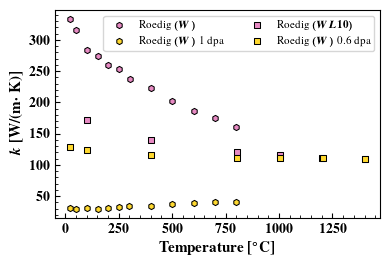

In [15]:

fig,ax = plt.subplots(figsize = (4,2.75))
setup_axis_default(ax)

roedig_marker_map = {'Pure W': 'h', 
                     'Pure W Irradiated 1 dpa': 'h', 
                     'WL10': 's', 
                     'WL10 Irradiated 0.6 dpa': 's'}

roedig_label_map = {'Pure W': 'Roedig $(W)$', 
                     'Pure W Irradiated 1 dpa': 'Roedig $(W)$ 1 dpa', 
                     'WL10': 'Roedig $(WL10)$', 
                     'WL10 Irradiated 0.6 dpa': 'Roedig $(W)$ 0.6 dpa'}


roedig_df = pd.read_csv('conductivity_data/roedig_data.csv',index_col = 0)
colors = plt.get_cmap('Set2')([0.4,0.7,0.4,0.7])
for col,color in zip(roedig_label_map,colors):
    ax.scatter(roedig_df.index - 273.15,roedig_df[col].to_numpy(),s =MARKER_SIZE,
               marker = roedig_marker_map[col],edgecolor = 'k',facecolor = color,
               label = roedig_label_map[col],alpha = ALPHA,lw = 0.75)
    
ax.set_xlabel(r'\textbf{Temperature [}$^\circ$\textbf{C]}',fontsize = 11)
ax.set_ylabel(r'$k$ \textbf{[W/(m}$\cdot$\textbf{ K)]}',fontsize = 11)
ax.tick_params('both',labelsize = 10,direction = 'in',which = 'both')


ax.legend(fontsize = 8,ncols = 2)
fig.tight_layout()